In [139]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import glob
import os
import wandb
import re
from collections import defaultdict

In [140]:
api = wandb.Api()

In [141]:
def pre_process(run: str):
    path = "run-"+run+".npz"
    data = np.load(path)
    
    # files
    y_next = data['y_next']
    z_next = data['z_next']
    mean = data['mean']
    variance = data['variance']
    
    shaped_y_next = np.reshape(y_next,-1)
    shaped_z_next = np.reshape(z_next,(-1,256))
    shaped_mean = np.reshape(mean,(-1,1))
    shaped_variance = np.reshape(variance,(-1,1))
    
    z_mask = ~np.isnan(shaped_z_next).all(axis=1)
    
    filtered_y = shaped_y_next[z_mask]
    filtered_mean = shaped_mean[z_mask]
    filtered_variance = shaped_variance[z_mask]
    print("Finished Processing " + path)
    return (filtered_y, filtered_mean, filtered_variance)
    


In [161]:
def plot_averaged_scores(score_lists, chunk_size, labels,title=None):

    plt.figure(figsize=(8, 6))
    
    for scores, label in zip(score_lists, labels):
        steps = np.arange(len(scores)) 
        
        cumulative_max_scores = np.maximum.accumulate(scores)

        # Plot each set of scores
        plt.plot(steps, cumulative_max_scores, label=label, linewidth=1)
    
    # Customize the plot
    plt.title(title, fontsize=14)
    plt.ylabel("Averaged Best Score", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    if title:
        plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight')
        print("Plotted" + title)


In [162]:
def plot_data(data,task,tag,ax=None):
    Y_true = data[0]
    mean = data[1]
    variance = data[2]
    title = task+" " + tag
    q_lower = mean - 1.96 * np.sqrt(variance)
    q_upper = mean + 1.96 * np.sqrt(variance)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    q_middle = mean.squeeze()
    q_lower = q_lower.squeeze()
    q_upper = q_upper.squeeze()
    Y_true = Y_true.squeeze()
    
    min_val = np.minimum(Y_true.min(),q_lower.min())
    max_val = np.maximum(Y_true.max(),q_lower.max())
    
    
    min_val, max_val = min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val)
    ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
    print(min_val)
    print(max_val)
    yerr1, yerr2 = q_middle - q_lower, q_upper - q_middle
    
    yerr = np.vstack([yerr2,yerr1])
    
    # creating our colors
    n = len(Y_true)
    indices = np.linspace(0,1,n)
    cmap = mp.colormaps['winter']
    
    markers, caps, bars = ax.errorbar(
        q_middle,
        Y_true,
        yerr=yerr,
        fmt=".",
        alpha=0.6,
        elinewidth=2.0,
        ms=14,
        ecolor="gray",
    )
    [bar.set_alpha(0.8) for bar in bars]
    [cap.set_alpha(1) for cap in caps]
    ax.set_xlim([-0.1, max_val])
    ax.set_ylim([min_val, max_val*3])
    plt.xlabel("Predicated Values")
    plt.ylabel("Oracle Values")
    plt.title(title)
    ax.grid(True)
    sc = ax.scatter(
        q_middle,
        Y_true,
        s=50,  # make smaller maybe
        marker="o",
        c=indices,
        cmap=cmap,
        edgecolors="black",
        zorder=3,  # make it go on top
    )
    cbar = plt.colorbar(sc)
    
    os.makedirs(task, exist_ok=True)
    
    path_to_save = f"{task}/{tag}.png"
    
    plt.savefig(path_to_save,dpi=300, bbox_inches='tight')
    
    print(f"plot saved to {path_to_save}")
    
    

In [163]:
entity = "joh22439-university-of-minnesota"
project = "optimimze-guacamol"


In [164]:
runs = api.runs(f"{entity}/{project}")

In [165]:
lst = os.listdir()
lst = lst[3:]

In [166]:

for i in range(len(lst)):
    text = lst[i]
    pattern = r"-(.*?)(\.)"
    match = re.search(pattern, text)
    if match:
        extracted_text = match.group(1)  # The text between '-' and '.'
        lst[i] = extracted_text
lst = set(lst)

In [167]:
my_runs = []
for run in runs:
    if run.name in lst:
        my_runs.append(run)
        print(f"Run Name: {run.name}")
        print(f"Tags: {run.tags}, {type(run.tags)}")

Run Name: gallant-aardvark-53
Tags: ['spectral-norm'], <class 'list'>
Run Name: ethereal-darkness-57
Tags: ['non-spectral'], <class 'list'>
Run Name: earthy-salad-59
Tags: ['spectral-norm'], <class 'list'>
Run Name: gentle-forest-60
Tags: ['non-spectral'], <class 'list'>
Run Name: blooming-sea-61
Tags: ['spectral-norm'], <class 'list'>
Run Name: bumbling-dawn-62
Tags: ['non-spectral'], <class 'list'>
Run Name: generous-snowball-63
Tags: ['non-spectral', 'variational ELBO'], <class 'list'>
Run Name: magic-dream-64
Tags: ['spectral-norm', 'variational ELBO'], <class 'list'>
Run Name: vital-galaxy-65
Tags: ['spectral-norm', 'variational ELBO'], <class 'list'>
Run Name: radiant-dawn-66
Tags: ['spectral-norm', 'variational ELBO'], <class 'list'>
Run Name: deep-voice-67
Tags: ['non-spectral', 'variational ELBO'], <class 'list'>
Run Name: vague-resonance-68
Tags: ['non-spectral', 'variational ELBO'], <class 'list'>


In [168]:
my_runs

[<Run joh22439-university-of-minnesota/optimimze-guacamol/7w5w52je (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/v1fc1e33 (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/zvditzko (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/308y821d (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/o54bl8dl (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/pnbtopbc (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/3rgiis0o (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/53zt1bv4 (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/qpckbl2u (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/1du1f68t (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/3pgxz95n (finished)>,
 <Run joh22439-university-of-minnesota/optimimze-guacamol/bv4yrsab (finished)>]

In [169]:
mapping = {"med2":['vague-resonance-68','earthy-salad-59','gentle-forest-60'],"pdop":['gallant-aardvark-53','ethereal-darkness-57','generous-snowball-63','magic-dream-64'],"med1":['blooming-sea-61','bumbling-dawn-62','vital-galaxy-65','deep-voice-67']}

In [170]:
name_to_run = defaultdict(str)

In [171]:
for run in my_runs:
    name_to_run[run.name] = run

Finished Processing run-vague-resonance-68.npz
-2.2449383773466463
0.43178324090099934
plot saved to med2/non-spectral-variational ELBO.png
Finished Processing run-earthy-salad-59.npz
-1.3501081706995643
0.28581645697987623
plot saved to med2/spectral-norm.png
Finished Processing run-gentle-forest-60.npz
-2.233640914218788
0.402113731333427
plot saved to med2/non-spectral.png
Plottedmed2
Finished Processing run-gallant-aardvark-53.npz
-2.2890605896524034
0.7174996999825927
plot saved to pdop/spectral-norm.png
Finished Processing run-ethereal-darkness-57.npz
-2.257229214366134
0.7403060794019823
plot saved to pdop/non-spectral.png
Finished Processing run-generous-snowball-63.npz
-2.273917038495315
0.7294799405383092
plot saved to pdop/non-spectral-variational ELBO.png
Finished Processing run-magic-dream-64.npz
-2.3080329960796697
0.6081648596473634
plot saved to pdop/spectral-norm-variational ELBO.png
Plottedpdop
Finished Processing run-blooming-sea-61.npz
-1.3394739459525724
0.39674621

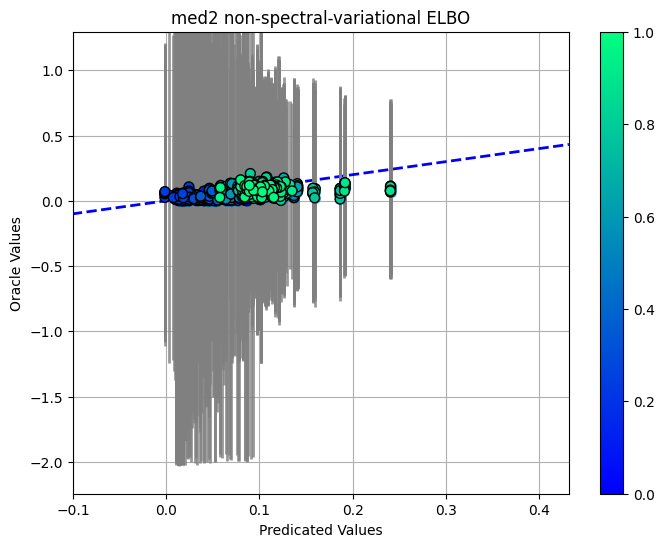

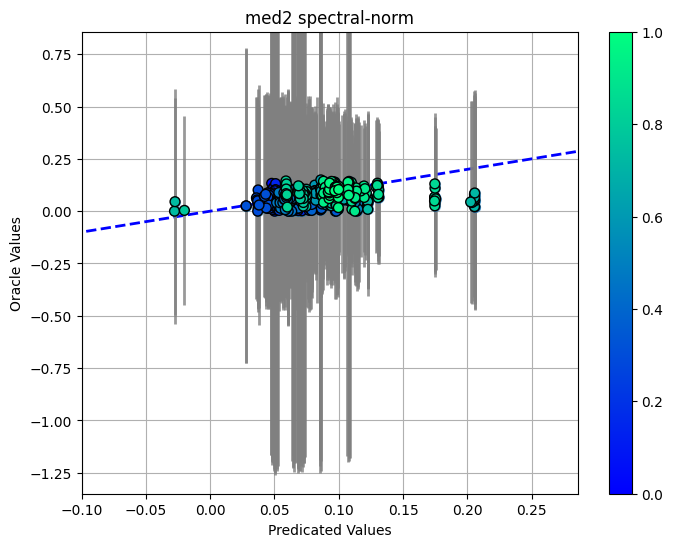

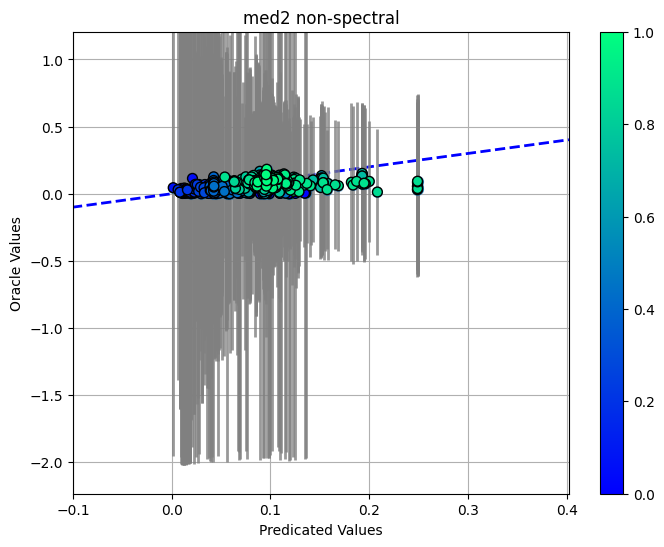

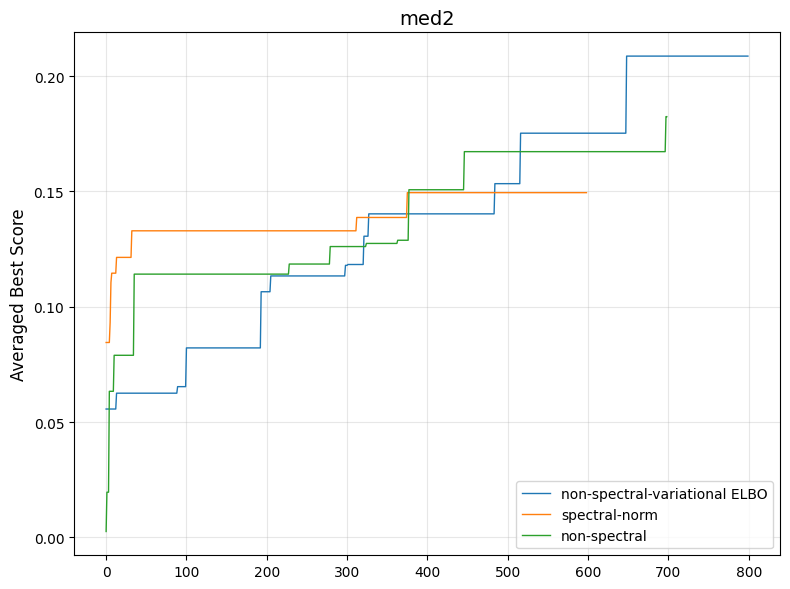

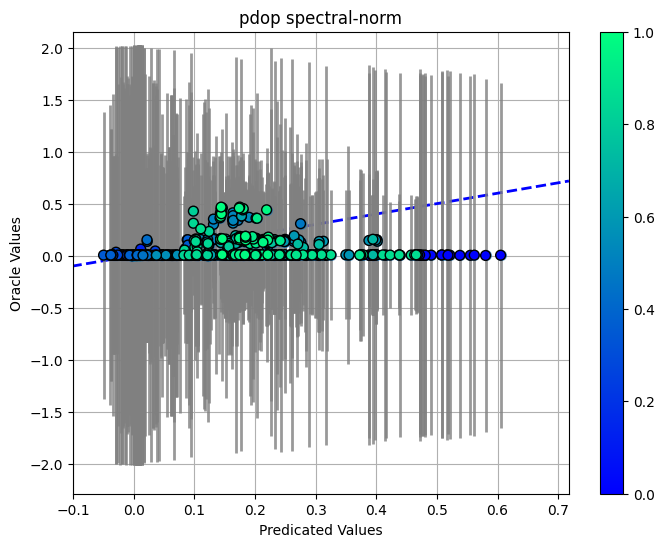

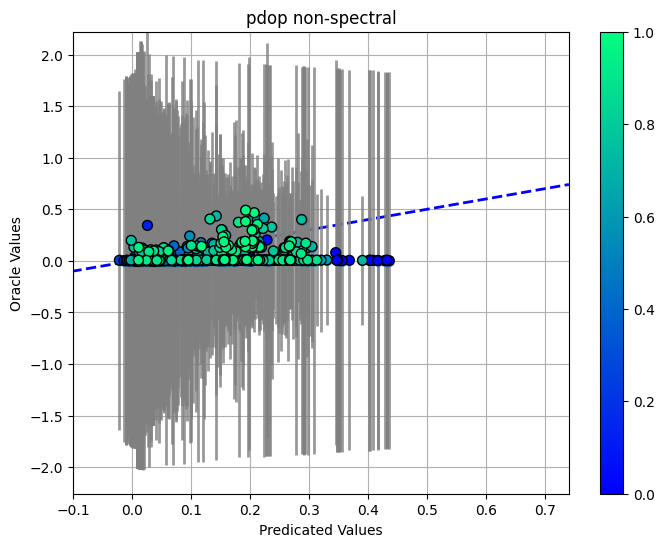

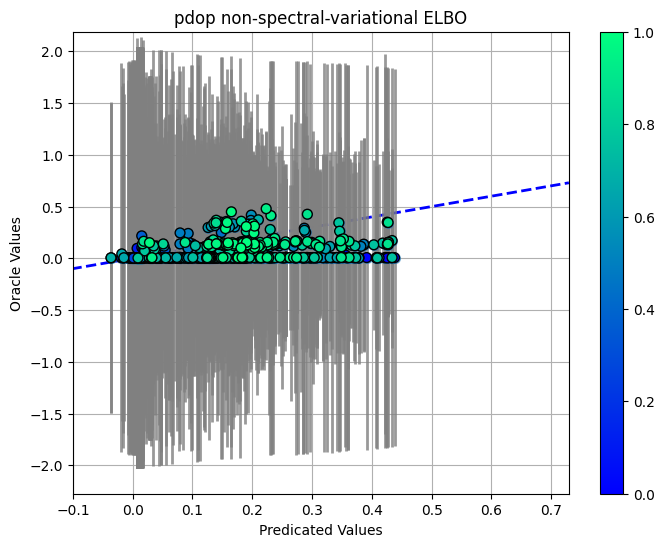

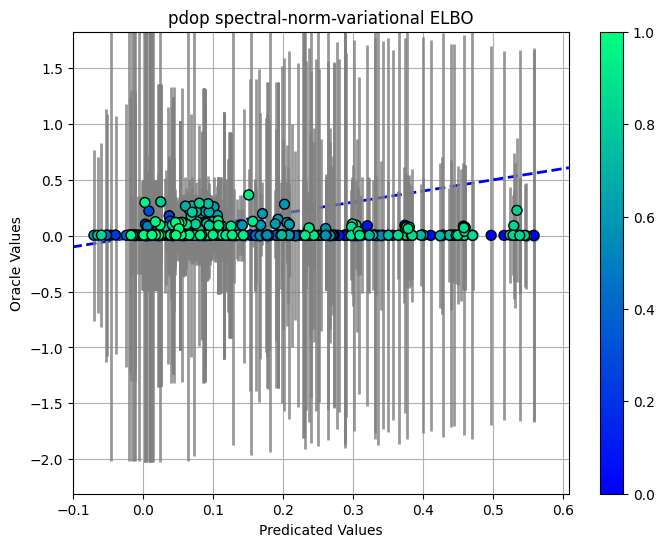

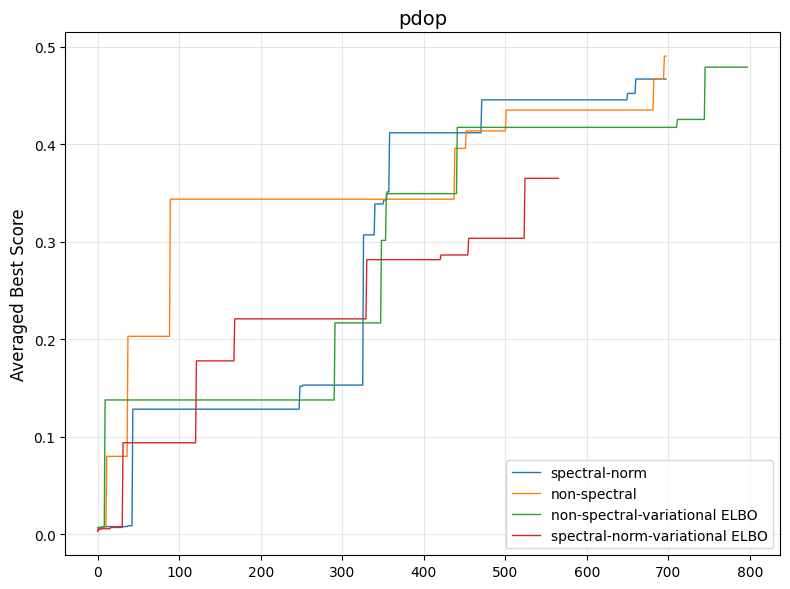

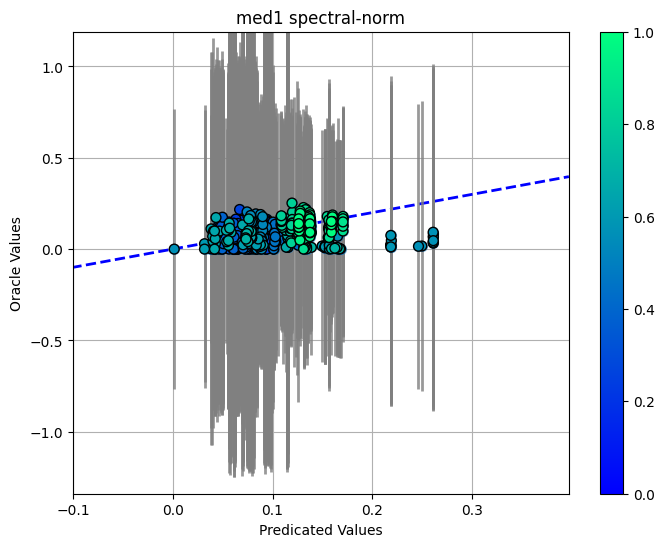

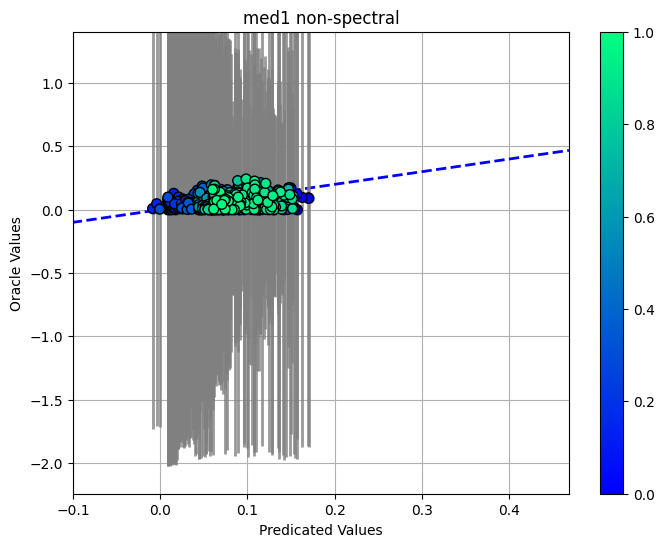

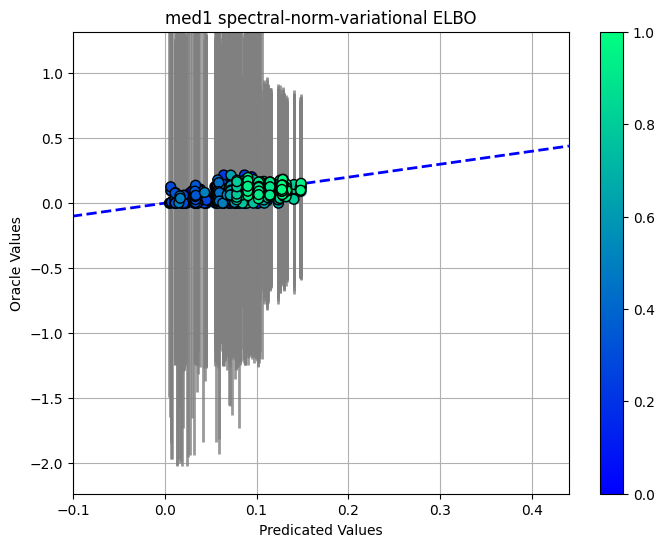

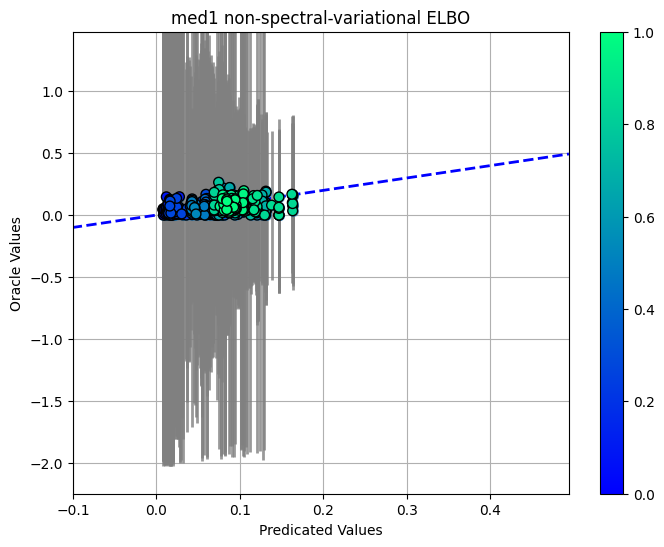

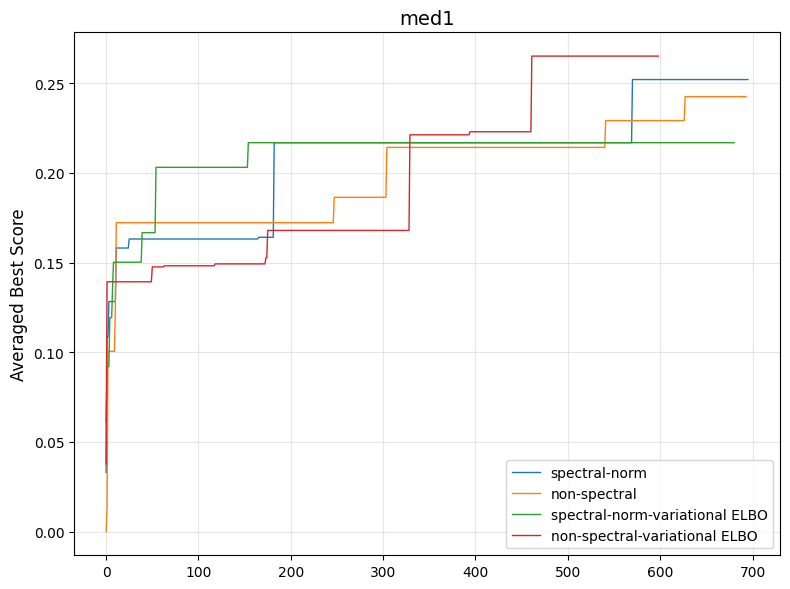

In [172]:
for task in mapping.keys():
    lst = mapping[task]
    scores_list = []
    tags_list = []
    for name in lst:
        if name in name_to_run:
            current_run = name_to_run[name]
            tag = "-".join(current_run.tags)
            tags_list.append(tag)
            current_tuple = pre_process(current_run.name)
            scores_list.append(current_tuple[0])
            
            plot_data(current_tuple,task,tag)
    
    plot_averaged_scores(scores_list,10,tags_list,title=task)
    
    

In [173]:
for task in mapping.keys():
    print(task)
    lst = mapping[task]
    for name in lst:
        if name in name_to_run:
            current_run = name_to_run[name]
            tag = "-".join(current_run.tags)
            rcreated_at = current_run.created_at  
            rfinished_at = current_run.finished_at
            time = rfinished_at - rcreated_at

    
    
    

med2


AttributeError: '<Run joh22439-university-of-minnesota/optimimze-guacamol/bv4yrsab (finished)>' object has no attribute 'finished_at'